In [11]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
%matplotlib inline 
plt.style.use('ggplot')
# Disable Python INFO and WARNING messages
warnings.filterwarnings('ignore')

In [12]:
# Load international online transactions data from CSV
df = pd.read_csv('data/int_online_tx.csv')
entries = df.shape[0]
features = df.shape[1]

## 1. Initial exploration 

**Goal** : Take a look at the online transactions data

#### Dataset basic information

In [13]:
# check the overall dataset structure 
df.shape

(35116, 8)

In [5]:
df.dtypes

InvoiceNo        int64
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

In [14]:
df.head()

InvoiceNo StockCode                      Description  Quantity  \
0     536370     22728        ALARM CLOCK BAKELIKE PINK        24   
1     536370     22727        ALARM CLOCK BAKELIKE RED         24   
2     536370     22726       ALARM CLOCK BAKELIKE GREEN        12   
3     536370     21724  PANDA AND BUNNIES STICKER SHEET        12   
4     536370     21883                 STARS GIFT TAPE         24   

    InvoiceDate  UnitPrice  CustomerID Country  
0  12/1/10 8:45       3.75     12583.0  France  
1  12/1/10 8:45       3.75     12583.0  France  
2  12/1/10 8:45       3.75     12583.0  France  
3  12/1/10 8:45       0.85     12583.0  France  
4  12/1/10 8:45       0.65     12583.0  France

#### Distributions of transactions by country

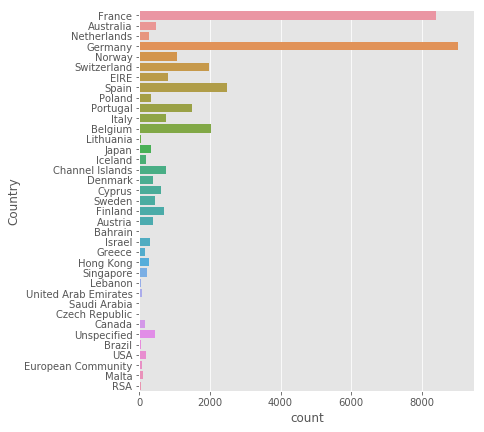

In [15]:
# Make figsize 6x7
plt.figure(figsize=(6,7))

# Bar plot by country
sns.countplot(y='Country', data=df)

We have many sparse classes when looking at the number of transactions by country. Considering each customer can have multiple transactions, we might even have smaller a number of customers by country.

## 2. Data cleaning 

#### Handling missing data

In [16]:
# Missing data by feature
df.isnull().sum()

InvoiceNo         0
StockCode         0
Description       0
Quantity          0
InvoiceDate       0
UnitPrice         0
CustomerID     1418
Country           0
dtype: int64

In [17]:
# Only keep transactions with CustomerID's
df = df[df.CustomerID.notnull()]
print( 'Removed entries :', entries - df.shape[0] )
print( 'Removed features :', features - df.shape[1] )

Removed entries : 1418
Removed features : 0


We dropped observations from missing customers, instead of keeping the data missingness as an information, because labelling them as 'Missing' assumes that a single customer 'Missing' will have the associated transactions. Such an assumption is false meaning those missing customers are considered as unwanted observations.

#### Fix structural errors

In [18]:
# Convert customer ID's into integers
df['CustomerID'] = df.CustomerID.astype(int)

# Display first 5 CustomerID's in the transaction dataset
df.CustomerID.head()

0    12583
1    12583
2    12583
3    12583
4    12583
Name: CustomerID, dtype: int64

In [19]:
# Create 'Sales' interaction feature
df['Sales'] = df.Quantity * df.UnitPrice

# Display first 5 Sales values in the transaction dataset
df.Sales.head()

0    90.0
1    90.0
2    45.0
3    10.2
4    15.6
Name: Sales, dtype: float64

In [21]:
# Save cleaned transaction-level data
df.to_csv('data/cleaned_transactions.csv', index=None)

## 3. Feature engineering

In [22]:
# Aggegrate invoice data
invoice_data = df.groupby('CustomerID').InvoiceNo.agg({ 'total_transactions' : 'nunique' })

# Display invoice data for first 5 customers
invoice_data.head()

total_transactions
CustomerID                    
12347                        7
12348                        4
12349                        1
12350                        1
12352                        8

In [23]:
# Aggregate product data
product_data = df.groupby('CustomerID').StockCode.agg( { 'total_products' : 'count', 
                                                         'total_unique_products' : 'nunique' } )

# Display product data for first 5 customers
product_data.head()

total_products  total_unique_products
CustomerID                                       
12347                  182                    103
12348                   31                     22
12349                   73                     73
12350                   17                     17
12352                   85                     59

In [24]:
# Roll up sales data
sales_data = df.groupby('CustomerID').Sales.agg( { 'total_sales' : 'sum', 
                                                  'avg_product_value' : 'mean' } )

# Display sales data for first 5 customers
sales_data.head()

avg_product_value  total_sales
CustomerID                                
12347               23.681319      4310.00
12348               57.975484      1797.24
12349               24.076027      1757.55
12350               19.670588       334.40
12352               29.482824      2506.04

In [25]:
# Aggregate cart-level data (i.e. invoice-level)
cart_data = df.groupby(['CustomerID' , 'InvoiceNo']).Sales.agg( { 'cart_value' : 'sum' })

# Reset index
cart_data.reset_index(inplace=True)

# Display cart data for first 5 CARTS
cart_data.head()

CustomerID  InvoiceNo  cart_value
0       12347     537626      711.79
1       12347     542237      475.39
2       12347     549222      636.25
3       12347     556201      382.52
4       12347     562032      584.91

In [26]:
# Aggregate cart data (at customer-level)
agg_cart_data = cart_data.groupby('CustomerID').cart_value.agg( { 'avg_cart_value' : 'mean', 
                                                                 'min_cart_value' : 'min',
                                                                 'max_cart_value' : 'max'})

# Display cart data for first 5 CUSTOMERS
agg_cart_data.head()

avg_cart_value  max_cart_value  min_cart_value
CustomerID                                                
12347           615.714286         1294.32          224.82
12348           449.310000          892.80          227.44
12349          1757.550000         1757.55         1757.55
12350           334.400000          334.40          334.40
12352           313.255000          840.30          120.33

In [27]:
# Join together customer-level ABT
customer_df = invoice_data.join([product_data, sales_data, agg_cart_data])

# Display customer-level data for first 5 customers
customer_df.head()

total_transactions  total_products  total_unique_products  \
CustomerID                                                              
12347                        7             182                    103   
12348                        4              31                     22   
12349                        1              73                     73   
12350                        1              17                     17   
12352                        8              85                     59   

            avg_product_value  total_sales  avg_cart_value  max_cart_value  \
CustomerID                                                                   
12347               23.681319      4310.00      615.714286         1294.32   
12348               57.975484      1797.24      449.310000          892.80   
12349               24.076027      1757.55     1757.550000         1757.55   
12350               19.670588       334.40      334.400000          334.40   
12352               29.482824      2506.04      313.255000          840.30   

            min_cart_value  
CustomerID                  
12347               224.82  
12348               227.44  
12349              1757.55  
12350               334.40  
12352               120.33

In [28]:
# Save analytical base table
customer_df.to_csv('data/analytical_base_table.csv')